El modelo de bert entrenado 2 epochs extra desde el orignal, para ver su resolucion

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import DataLoader, Subset


dataset = load_dataset('imdb')

def reduce_dataset(dataset, factor=10):
    reduced_dataset = {}
    for split in dataset.keys():
        labels = np.array(dataset[split]['label'])
        num_per_class = (len(labels) // (2 * factor))

        indices_0 = np.where(labels == 0)[0][:num_per_class]
        indices_1 = np.where(labels == 1)[0][:num_per_class]

        indices = np.concatenate([indices_0, indices_1])
        np.random.shuffle(indices)

        reduced_dataset[split] = dataset[split].select(indices.tolist())
    return reduced_dataset

reduced_dataset = reduce_dataset(dataset)

tokenizer = BertTokenizer.from_pretrained('./trained_model') # esto se puede cambiar por el modelo nuevo 
                                                             # y se puede seguir entrenando o simplemente para clasificar
model = BertForSequenceClassification.from_pretrained('./trained_model')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = {}
for split in reduced_dataset.keys():
    tokenized_datasets[split] = reduced_dataset[split].map(tokenize_function, batched=True)

train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric = load_metric('accuracy')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # Continue training for 2 more epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

results = trainer.evaluate()
print(results)

model.save_pretrained('./final_model')
tokenizer.save_pretrained('./final_model')


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

C:\Users\alfon\AppData\Local\Temp\ipykernel_5284\148897892.py:52: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')
C:\Users\alfon\anaconda3\envs\text_classification_env\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
C:\Users\alfon\anaconda3\envs\text_classification_env\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.007500,0.458075,0.914400,0.912420,0.916800,0.914605
2,0.000500,0.501676,0.918800,0.929450,0.906400,0.917780


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5016756057739258, 'eval_accuracy': 0.9188, 'eval_precision': 0.9294503691550451, 'eval_recall': 0.9064, 'eval_f1': 0.917780477926286, 'eval_runtime': 550.0186, 'eval_samples_per_second': 4.545, 'eval_steps_per_second': 0.569, 'epoch': 2.0}


('./final_model\\tokenizer_config.json',
 './final_model\\special_tokens_map.json',
 './final_model\\vocab.txt',
 './final_model\\added_tokens.json')

Se ven accuracies bastante buenos, aunque con un claro problema de sobreentreno, visto con los losses de ambas, con el validation siendo 0.5
y el training subiendo. 

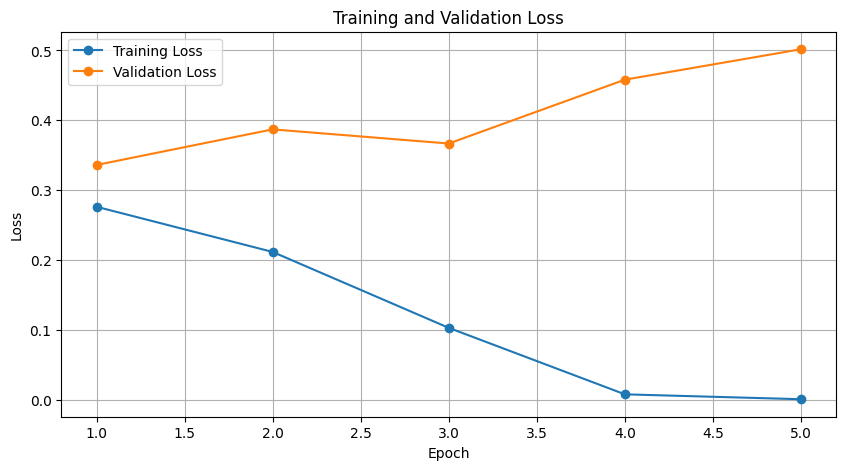

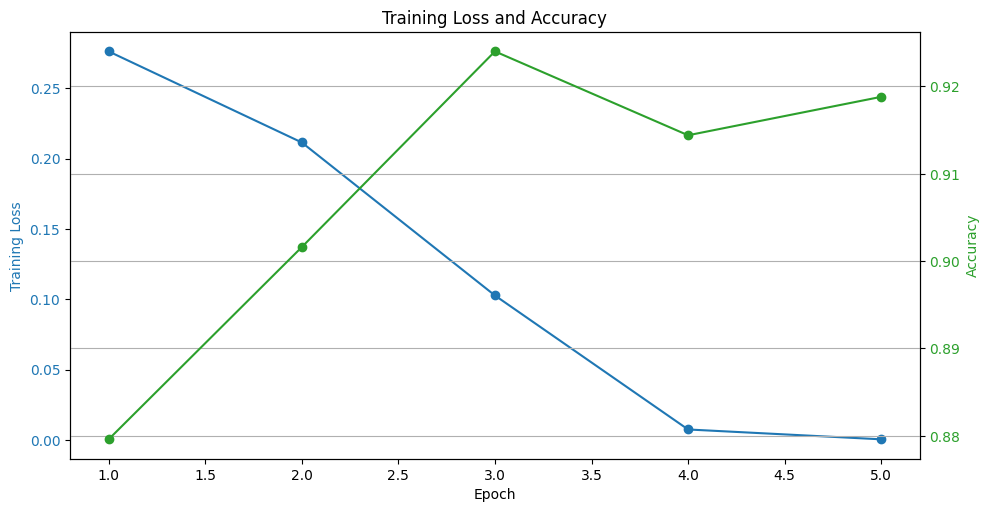

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Epoch": [1, 2, 3, 4, 5],
    "Training Loss": [0.276100, 0.211400, 0.102700, 0.007500, 0.000500],
    "Validation Loss": [0.335924, 0.386908, 0.366635, 0.458075, 0.501676],
    "Accuracy": [0.879600, 0.901600, 0.924000, 0.914400, 0.918800],
    "Precision": [0.821695, 0.857550, 0.918641, 0.912420, 0.929450],
    "Recall": [0.969600, 0.963200, 0.930400, 0.916800, 0.906400],
    "F1": [0.889541, 0.907310, 0.924483, 0.914605, 0.917780]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["Training Loss"], label="Training Loss", marker='o')
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(df["Epoch"], df["Training Loss"], label="Training Loss", marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color) 
ax2.plot(df["Epoch"], df["Accuracy"], label="Accuracy", marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Training Loss and Accuracy")
plt.grid(True)
plt.show()


Buenos graphs, pero claramente no mejoro mucho desde el 3ero, quizas con mas epochs se veria diferencias, pero seria muy poco probable viendo los lossess del training.

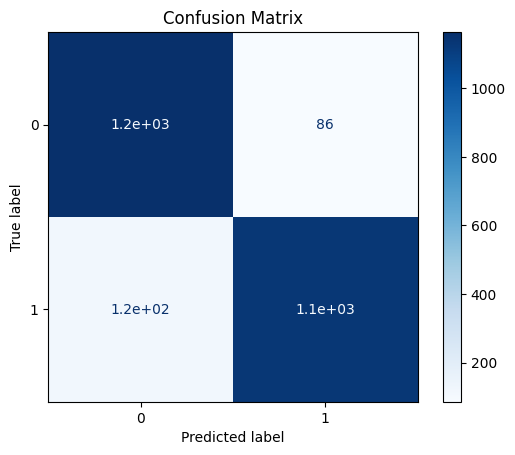

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(test_dataset)

labels = predictions.label_ids
preds = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [5]:
len(labels)

2500

Por alguna razon no aparece bien, pero son 1200 0,0  86 falsos positivos 0,1  120 falsos negativos1,0  y 1100 true positives(esto son aproximaciones, no puedo sacar todo, pero son aproximaciones por como ha salido el grafo)

Son muy buenos numeros, con un poco mas de predicciones negativas. 